In [5]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

In [6]:
! dir "E:\satdata"

 Volume in drive E is Data
 Volume Serial Number is 18AA-E419

 Directory of E:\satdata

04/15/2025  09:19 AM    <DIR>          .
04/15/2025  09:18 AM    <DIR>          Atchafalaya_2021-06-21_2021-07-21
04/15/2025  09:19 AM    <DIR>          Atchafalaya_2022-03-18_2022-04-16
04/15/2025  09:19 AM    <DIR>          Atchafalaya_2022-06-19_2022-07-19
04/15/2025  09:08 AM    <DIR>          Mississippi_2021-06-21_2021-07-21
04/15/2025  09:19 AM    <DIR>          Mississippi_2022-03-18_2022-04-16
04/15/2025  09:19 AM    <DIR>          Mississippi_2022-06-19_2022-07-19
               0 File(s)              0 bytes
               7 Dir(s)  1,728,219,213,824 bytes free


In [7]:
# Specify the data directory and search recursively for netCDF files (2021 dataset)
data_dir = r"E:\satdata\Atchafalaya_2021-06-21_2021-07-21"
nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)
loader = L2DatasetLoader(variable='chlor_a')
datasets = loader.load_multiple(nc_files)
print(f"Loaded {len(datasets)} datasets.")

Loaded 38 datasets.


In [ ]:
# Create an instance of GPUDataExtractor and extract data on GPU for first dataset
extractor = GPUDataExtractor('chlor_a')
all_lon, all_lat, all_var = extractor.extract(datasets)
print('GPU data extraction complete.')

from scipy.stats import binned_statistic_2d

# === Define Bounding Box for Chlorophyll-a Data (first dataset) ===
lon_min, lon_max = -95.0, -91.5
lat_min, lat_max = 28.0, 30.0

# === Clip data to the bounding box for first dataset ===
mask = ((all_lon >= lon_min) & (all_lon <= lon_max) & (all_lat >= lat_min) & (all_lat <= lat_max))
clipped_lon = all_lon[mask]
clipped_lat = all_lat[mask]
clipped_var = all_var[mask]

# === Define binning parameters and compute 2D binned mean statistic for first dataset ===
lat_bins, lon_bins = 200, 300
stat, lat_edges, lon_edges, _ = binned_statistic_2d(
    clipped_lat, clipped_lon, clipped_var, statistic='mean', bins=[lat_bins, lon_bins],
    range=[[lat_min, lat_max], [lon_min, lon_max]]
)

# === Generate meshgrid for pcolormesh using bin edges for first dataset ===
lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

GPU data extraction complete.


In [9]:
# Load second dataset for comparison and extract GPU data (2022 dataset)
data_dir2 = r"E:\satdata\Atchafalaya_2022-06-19_2022-07-19"
nc_files2 = glob.glob(os.path.join(data_dir2, '**', '*.nc'), recursive=True)
datasets2 = loader.load_multiple(nc_files2)
print(f"Loaded {len(datasets2)} datasets for 2022.")

# Extract GPU data from second dataset using the previously defined extractor
all_lon2, all_lat2, all_var2 = extractor.extract(datasets2)
print('GPU data extraction for 2022 complete.')

Loaded 46 datasets for 2022.
GPU data extraction for 2022 complete.
GPU data extraction for 2022 complete.


In [ ]:
# Define bounding box and clip second dataset to the bounding box
mask2 = ((all_lon2 >= lon_min) & (all_lon2 <= lon_max) & (all_lat2 >= lat_min) & (all_lat2 <= lat_max))
clipped_lon2 = all_lon2[mask2]
clipped_lat2 = all_lat2[mask2]
clipped_var2 = all_var2[mask2]

# Compute 2D binned mean statistic for second dataset
from scipy.stats import binned_statistic_2d
lat_bins, lon_bins = 200, 300
stat2, lat_edges2, lon_edges2, _ = binned_statistic_2d(
    clipped_lat2, clipped_lon2, clipped_var2,
    statistic='mean', bins=[lat_bins, lon_bins],
    range=[[lat_min, lat_max], [lon_min, lon_max]]
)

# Generate meshgrid for pcolormesh using bin edges (for second dataset)
lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

In [11]:
# === Generate meshgrid for pcolormesh using bin edges for 2022 dataset ===
lon_grid2, lat_grid2 = np.meshgrid(lon_edges2, lat_edges2)

In [12]:
# Process third dataset from Atchafalaya_2022-03-18_2022-04-16
data_dir3 = r"E:\satdata\Atchafalaya_2022-03-18_2022-04-16"
nc_files3 = glob.glob(os.path.join(data_dir3, '**', '*.nc'), recursive=True)
datasets3 = loader.load_multiple(nc_files3)
print(f"Loaded {len(datasets3)} datasets for 2022-03-18 to 2022-04-16.")

# Extract GPU data for the third dataset
all_lon3, all_lat3, all_var3 = extractor.extract(datasets3)
print('GPU data extraction for 2022-03-18 to 2022-04-16 complete.')

# Clip third dataset to the bounding box
mask3 = ((all_lon3 >= lon_min) & (all_lon3 <= lon_max) & (all_lat3 >= lat_min) & (all_lat3 <= lat_max))
clipped_lon3 = all_lon3[mask3]
clipped_lat3 = all_lat3[mask3]
clipped_var3 = all_var3[mask3]

# Compute 2D binned mean statistic for the third dataset
stat3, lat_edges3, lon_edges3, _ = binned_statistic_2d(
    clipped_lat3, clipped_lon3, clipped_var3, statistic='mean', bins=[lat_bins, lon_bins],
    range=[[lat_min, lat_max], [lon_min, lon_max]]
)

# Generate meshgrid for pcolormesh for the third dataset
lon_grid3, lat_grid3 = np.meshgrid(lon_edges3, lat_edges3)

Loaded 16 datasets for 2022-03-18 to 2022-04-16.
GPU data extraction for 2022-03-18 to 2022-04-16 complete.
GPU data extraction for 2022-03-18 to 2022-04-16 complete.


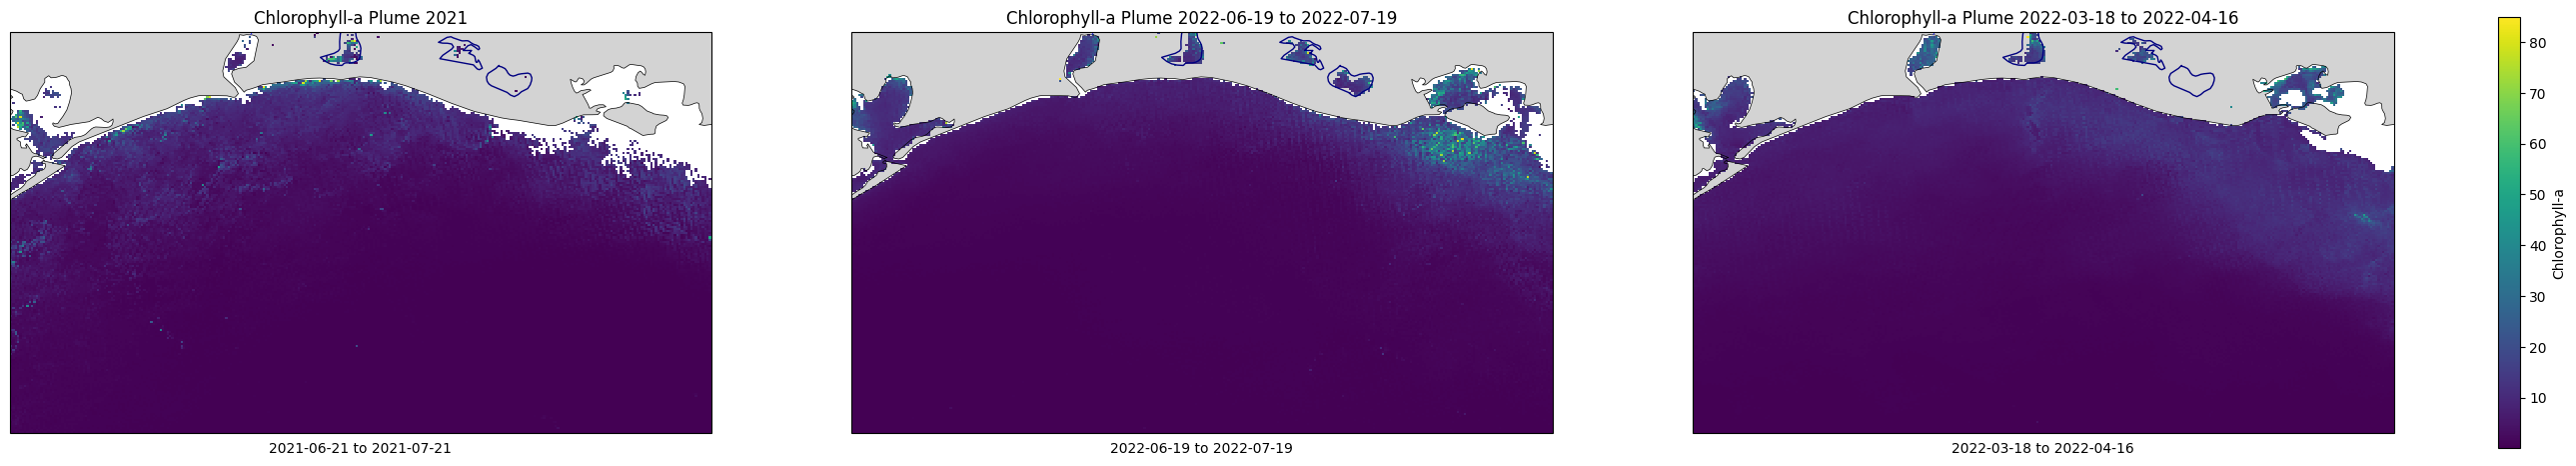

In [13]:
# Set the threshold for small regions
threshold = 32

# Apply SelectiveInterpolator on datasets
stat_selective_interp1 = SelectiveInterpolator.interpolate(stat, lat_edges, lon_edges, threshold)
stat_selective_interp2 = SelectiveInterpolator.interpolate(stat2, lat_edges, lon_edges, threshold)
stat_selective_interp3 = SelectiveInterpolator.interpolate(stat3, lat_edges3, lon_edges3, threshold)

# Create a figure with three subplots for side-by-side comparison
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(36, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot first dataset (2021)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
raster1 = ax1.pcolormesh(lon_grid, lat_grid, stat_selective_interp1, cmap='viridis', shading='auto', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
ax1.add_feature(cfeature.LAKES, facecolor='none', edgecolor='navy', linestyle='-')
ax1.set_title("Chlorophyll-a Plume 2021")

# Plot second dataset (2022-06-19 to 2022-07-19)
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
raster2 = ax2.pcolormesh(lon_grid, lat_grid, stat_selective_interp2, cmap='viridis', shading='auto', transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
ax2.add_feature(cfeature.LAKES, facecolor='none', edgecolor='navy', linestyle='-')
ax2.set_title("Chlorophyll-a Plume 2022-06-19 to 2022-07-19")

# Plot third dataset (2022-03-18 to 2022-04-16)
ax3.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
raster3 = ax3.pcolormesh(lon_grid3, lat_grid3, stat_selective_interp3, cmap='viridis', shading='auto', transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
ax3.add_feature(cfeature.LAKES, facecolor='none', edgecolor='navy', linestyle='-')
ax3.set_title("Chlorophyll-a Plume 2022-03-18 to 2022-04-16")

# Adjust layout to reserve space on the right
fig.subplots_adjust(right=0.85)

# Add a single colorbar for all subplots in the reserved space with adjusted height
cbar = fig.colorbar(raster1, ax=[ax1, ax2, ax3], orientation='vertical', fraction=0.046, pad=0.04, shrink=0.8, label='Chlorophyll-a')

# Add date range text for each subplot
ax1.text((lon_min + lon_max) / 2, lat_min - 0.1, "2021-06-21 to 2021-07-21", transform=ccrs.PlateCarree(), fontsize=10, color='black', ha='center')
ax2.text((lon_min + lon_max) / 2, lat_min - 0.1, "2022-06-19 to 2022-07-19", transform=ccrs.PlateCarree(), fontsize=10, color='black', ha='center')
ax3.text((lon_min + lon_max) / 2, lat_min - 0.1, "2022-03-18 to 2022-04-16", transform=ccrs.PlateCarree(), fontsize=10, color='black', ha='center')

plt.show()